# Imports

In [ ]:
!pip install googlemaps

In [43]:
import pandas as pd
import numpy as np
import googlemaps
import os
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
# from google.colab import drive
from IPython.display import clear_output
import psutil

# Inicializações

## Montando google drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

os.chdir('drive/MyDrive/Colab Notebooks/Reg Linear/')
os.listdir()

## Funções

In [44]:
gmaps = googlemaps.Client(key='')

In [45]:
def get_lat_lon(string:str) -> tuple:
    geocode_result = gmaps.geocode(string)
    
    try:
        lat = geocode_result[0]['geometry']['bounds']['northeast']['lat']
        lon = geocode_result[0]['geometry']['bounds']['northeast']['lng']
    except KeyError:
        lat = geocode_result[0]['geometry']['location']['lat']
        lon = geocode_result[0]['geometry']['location']['lng']
    except Exception:
        return False
    
    return (lat, lon)

In [46]:
def load_dataframes(file_location:str) -> pd.DataFrame:
    files = [os.path.join(file_location, file) for file in os.listdir(file_location) if file.lower().endswith('.csv')]
    columns=['regiao','estado','municipio','revenda','cnpj','nomeRua','numRua','complemento','bairro','cep','produto','dataColeta','valorVenda','valorCompra','unidadeMedida','bandeira']
    
    dataframes = []
    for file in files:
        print(file)
        dataframe = pd.read_csv(file, encoding='latin1', delimiter=';', header=None, skiprows=1)
        dataframe.columns = columns
        
        dataframes.append(dataframe)
    
    return pd.concat(dataframes)

## Carregando dataset

In [47]:
columns = ['regiao', 'estado', 'municipio', 'revenda', 'cnpj', 'nomeRua', 'numRua', 'complemento', 'bairro', 'cep', 'produto', 'dataColeta', 'valorVenda', 'valorCompra', 'unidadeMedida', 'bandeira']
dataframe = pd.concat([pd.read_csv('./datasets/ca-2021-01.csv', encoding='latin1', delimiter=';', header=None, skiprows=1), pd.read_csv('./datasets/ca-2021-02.csv', encoding='latin1', delimiter=';', header=None, skiprows=1)])
dataframe.columns = columns

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807537 entries, 0 to 472855
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   regiao         807537 non-null  object 
 1   estado         807537 non-null  object 
 2   municipio      807537 non-null  object 
 3   revenda        807537 non-null  object 
 4   cnpj           807537 non-null  object 
 5   nomeRua        807537 non-null  object 
 6   numRua         807222 non-null  object 
 7   complemento    165365 non-null  object 
 8   bairro         805808 non-null  object 
 9   cep            807537 non-null  object 
 10  produto        807537 non-null  object 
 11  dataColeta     807537 non-null  object 
 12  valorVenda     807537 non-null  object 
 13  valorCompra    0 non-null       float64
 14  unidadeMedida  807537 non-null  object 
 15  bandeira       807537 non-null  object 
dtypes: float64(1), object(15)
memory usage: 104.7+ MB


In [48]:
columns = ['regiao', 'estado', 'municipio', 'revenda', 'cnpj', 'nomeRua', 'numRua', 'complemento', 'bairro', 'cep', 'produto', 'dataColeta', 'valorVenda', 'valorCompra', 'unidadeMedida', 'bandeira']
dataframe = load_dataframes('datasets')
dataframe.columns = columns

dataframe.info()

datasets/ca-2020-01.csv
datasets/ca-2021-01.csv
datasets/ca-2021-02.csv
datasets/ca-2022-01.csv
datasets/ca-2020-02.csv


/tmp/ipykernel_804/3733141540.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file, encoding='latin1', delimiter=';', header=None, skiprows=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056261 entries, 0 to 222636
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   regiao         object
 1   estado         object
 2   municipio      object
 3   revenda        object
 4   cnpj           object
 5   nomeRua        object
 6   numRua         object
 7   complemento    object
 8   bairro         object
 9   cep            object
 10  produto        object
 11  dataColeta     object
 12  valorVenda     object
 13  valorCompra    object
 14  unidadeMedida  object
 15  bandeira       object
dtypes: object(16)
memory usage: 266.7+ MB


In [49]:
dataframe

,regiao,estado,municipio,revenda,cnpj,nomeRua,numRua,complemento,bairro,cep,produto,dataColeta,valorVenda,valorCompra,unidadeMedida,bandeira
0,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GASOLINA,03/01/2020,"4,399",NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
1,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,ETANOL,03/01/2020,"3,199",NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,03/01/2020,"3,899",NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
3,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GNV,03/01/2020,"2,995",NaN,R$ / mÂ³,PETROBRAS DISTRIBUIDORA S.A.
4,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NaN,STIEP,41770-395,GASOLINA,03/01/2020,"4,69","4,1743",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222632,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,GASOLINA,29/12/2020,"4,999",NaN,R$ / litro,RAIZEN
222633,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,DIESEL,29/12/2020,"3,699",NaN,R$ / litro,RAIZEN
222634,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,ETANOL,29/12/2020,"4,299",NaN,R$ / litro,RAIZEN
222635,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,GASOLINA ADITIVADA,29/12/2020,"5,199",NaN,R$ / litro,RAIZEN


# Limpeza e transformação dos dados

In [50]:
# Retirando linhas exatamente iguais

dataframe = dataframe.drop_duplicates()

In [51]:
# Alterando delimitador decimal para ponto: 1,5 -> 1.5

dataframe['valorVenda'] = dataframe.valorVenda.replace(',', '.', regex=True)

In [52]:
dataframe

,regiao,estado,municipio,revenda,cnpj,nomeRua,numRua,complemento,bairro,cep,produto,dataColeta,valorVenda,valorCompra,unidadeMedida,bandeira
0,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GASOLINA,03/01/2020,4.399,NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
1,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,ETANOL,03/01/2020,3.199,NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,03/01/2020,3.899,NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
3,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GNV,03/01/2020,2.995,NaN,R$ / mÂ³,PETROBRAS DISTRIBUIDORA S.A.
4,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NaN,STIEP,41770-395,GASOLINA,03/01/2020,4.69,"4,1743",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222632,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,GASOLINA,29/12/2020,4.999,NaN,R$ / litro,RAIZEN
222633,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,DIESEL,29/12/2020,3.699,NaN,R$ / litro,RAIZEN
222634,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,ETANOL,29/12/2020,4.299,NaN,R$ / litro,RAIZEN
222635,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,GASOLINA ADITIVADA,29/12/2020,5.199,NaN,R$ / litro,RAIZEN


In [53]:
# Retirando todos as linhas que contém os seguintes dados vazios
# - bandeira
# - nome da rua
# - cep
# - bairro
# - municipio
# - estado

drop_indexes = list(dataframe[dataframe['bandeira'].isna()].index) + list(dataframe[dataframe['nomeRua'].isna()].index) + list(dataframe[dataframe['cep'].isna()].index) + list(dataframe[dataframe['bairro'].isna()].index) + list(dataframe[dataframe['municipio'].isna()].index) + list(dataframe[dataframe['estado'].isna()].index)

dataframe = dataframe.drop(drop_indexes)

In [54]:
# Selecionando apenas os registros que são referentes a GASOLINA

dataframe = dataframe[dataframe['produto'].str.upper() == 'GASOLINA']

In [55]:
dataframe = dataframe.sample(n=round(len(dataframe) * 0.03))

In [57]:
# Resetando o index, pois foram selecionados dados aleatórios

dataframe = dataframe.reset_index(drop=True)

In [58]:
dataframe.columns

Index(['regiao', 'estado', 'municipio', 'revenda', 'cnpj', 'nomeRua', 'numRua',
       'complemento', 'bairro', 'cep', 'produto', 'dataColeta', 'valorVenda',
       'valorCompra', 'unidadeMedida', 'bandeira'],
      dtype='object')

In [59]:
# Criando novo dataframe que irá conter os dados por coordenadas

new_columns = ['regiao', 'estado', 'latitude', 'longitude', 'dataColeta', 'valorVenda']
new_df = pd.DataFrame(columns=new_columns)
new_df

,regiao,estado,latitude,longitude,dataColeta,valorVenda


In [60]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16335 entries, 0 to 16334
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   regiao         16335 non-null  object
 1   estado         16335 non-null  object
 2   municipio      16335 non-null  object
 3   revenda        16335 non-null  object
 4   cnpj           16335 non-null  object
 5   nomeRua        16335 non-null  object
 6   numRua         16329 non-null  object
 7   complemento    3729 non-null   object
 8   bairro         16335 non-null  object
 9   cep            16335 non-null  object
 10  produto        16335 non-null  object
 11  dataColeta     16335 non-null  object
 12  valorVenda     16335 non-null  object
 13  valorCompra    1448 non-null   object
 14  unidadeMedida  16335 non-null  object
 15  bandeira       16335 non-null  object
dtypes: object(16)
memory usage: 2.0+ MB


In [61]:
# Busca a coordenada para cada linha do dataset. Se o endereço não for encontrado, o registro será ignorado

for index, row in dataframe.iterrows():
    search_location = f'{row["bandeira"]}, {row["nomeRua"]}, {row["cep"]}, {row["bairro"]}, {row["municipio"]}, {row["estado"]}'

    if index % 25 == 0:
        clear_output()
    # print(f'[ {str(index).rjust(len(str(len(dataframe))), " ")} / {len(dataframe)} ]')
        print(f'{round((index/len(dataframe))*100, 2)}%')
        print(f'RAM Usage(GB)  - Process: {round(psutil.Process().memory_info().vms / 1024 ** 2 / 1024, 2)}')
        print("")
        print(f'RAM Usage(%)   - Total..: {psutil.virtual_memory()[2]}%')
        print(f'RAM Usage (GB) - Total..: {round(psutil.virtual_memory()[3], 2)}')
    
    try:
        coordinates = get_lat_lon(search_location)

        if coordinates == False:
          continue

        values_to_append = [
            row['regiao'],
            row['estado'],
            coordinates[0],
            coordinates[1],
            row['dataColeta'],
            row['valorVenda']
        ]
    
        new_df.loc[len(new_df)] = values_to_append
    except googlemaps.exceptions.HTTPError as err:
        ...

1.0%
RAM Usage(GB)  - Process: 3.26

RAM Usage(%)   - Total..: 69.2%
RAM Usage (GB) - Total..: 5.43


## Checkpoint

In [62]:
# Salva o novo dataset em um novo arquivo

new_df.to_csv(f'processed_2020_2022-1_3percent.csv', encoding='latin1', index=False)

In [ ]:
del new_df

In [151]:
new_df = pd.read_csv('processed_2020_2022-1_3percent.csv', encoding='latin1')

In [152]:
new_df

,regiao,estado,latitude,longitude,dataColeta,valorVenda
0,SE,SP,-23.563606,-46.797844,09/07/2020,3.899
1,SE,SP,-22.655435,-50.402921,02/05/2021,5.390
2,SE,RJ,-22.912941,-43.228507,16/11/2020,4.797
3,SE,SP,-23.628771,-46.563056,28/06/2021,5.899
4,SE,SP,-23.489474,-46.315357,01/07/2020,3.799
...,...,...,...,...,...,...
15422,SE,SP,-22.310412,-49.075185,05/04/2022,6.150
15423,N,PA,-3.030564,-47.459877,04/02/2020,4.597
15424,S,RS,-29.723548,-50.265662,07/07/2021,6.349
15425,SE,RJ,-22.913192,-43.093748,23/09/2021,6.699


In [153]:
# Transforma a coluna 'regiao' em dummy variables e joga em um novo dataframe

regiao = pd.get_dummies(new_df['regiao'])
estado = pd.get_dummies(new_df['estado'])

In [154]:
regiao.columns=['centroOeste', 'norte', 'nordeste', 'sul', 'sudeste']

In [155]:
regiao

,centroOeste,norte,nordeste,sul,sudeste
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
15422,0,0,0,0,1
15423,0,1,0,0,0
15424,0,0,0,1,0
15425,0,0,0,0,1


In [156]:
# Concatena o dataframe com todos os dados e junto com as dummy variables da região e remove a coluna região

new_df = pd.concat([new_df, regiao, estado], axis=1)
new_df = new_df.drop(columns=['regiao', 'estado'])

In [157]:
# Transforma as colunas no seus respectivos tipos

new_df['latitude'] = new_df['latitude'].astype('float64')
new_df['longitude'] = new_df['longitude'].astype('float64')
new_df['valorVenda'] = new_df['valorVenda'].astype('float64')
new_df['dataColeta'] = pd.to_datetime(new_df['dataColeta'], format='%d/%m/%Y').map(datetime.datetime.toordinal)

In [159]:
new_df = new_df.sort_values(by=['dataColeta'])

In [160]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15427 entries, 1648 to 196
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   latitude     15427 non-null  float64
 1   longitude    15427 non-null  float64
 2   dataColeta   15427 non-null  int64  
 3   valorVenda   15427 non-null  float64
 4   centroOeste  15427 non-null  uint8  
 5   norte        15427 non-null  uint8  
 6   nordeste     15427 non-null  uint8  
 7   sul          15427 non-null  uint8  
 8   sudeste      15427 non-null  uint8  
 9   AC           15427 non-null  uint8  
 10  AL           15427 non-null  uint8  
 11  AM           15427 non-null  uint8  
 12  AP           15427 non-null  uint8  
 13  BA           15427 non-null  uint8  
 14  CE           15427 non-null  uint8  
 15  DF           15427 non-null  uint8  
 16  ES           15427 non-null  uint8  
 17  GO           15427 non-null  uint8  
 18  MA           15427 non-null  uint8  
 19  MG 

# Análise dos dados

In [161]:
new_df

,latitude,longitude,dataColeta,valorVenda,centroOeste,norte,nordeste,sul,sudeste,AC,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
1648,-26.350421,-49.122604,737425,4.370,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
12007,-26.261120,-48.840823,737425,4.199,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
12946,-24.560478,-54.145737,737425,4.570,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14626,-27.235862,-52.031791,737425,4.399,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
12537,-29.751191,-57.088051,737425,4.970,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,-24.032085,-52.388684,738336,6.390,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8100,-24.178281,-46.784434,738336,6.720,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9721,-21.265431,-44.981855,738336,7.310,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
912,-9.390247,-40.505519,738336,7.650,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: >

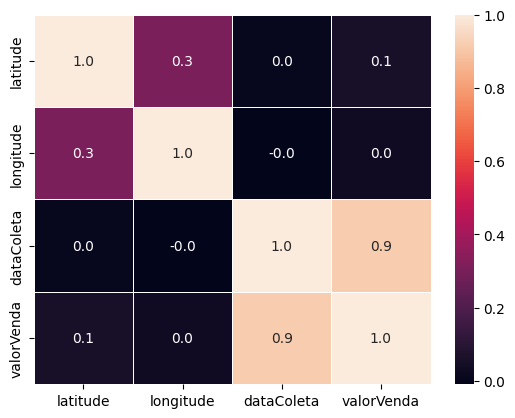

In [162]:
# Correlação entre as colunas do dataframe

correlation = new_df.iloc[:, :4].corr()
sns.heatmap(correlation, annot=True, fmt='.1f', linewidths=.6)

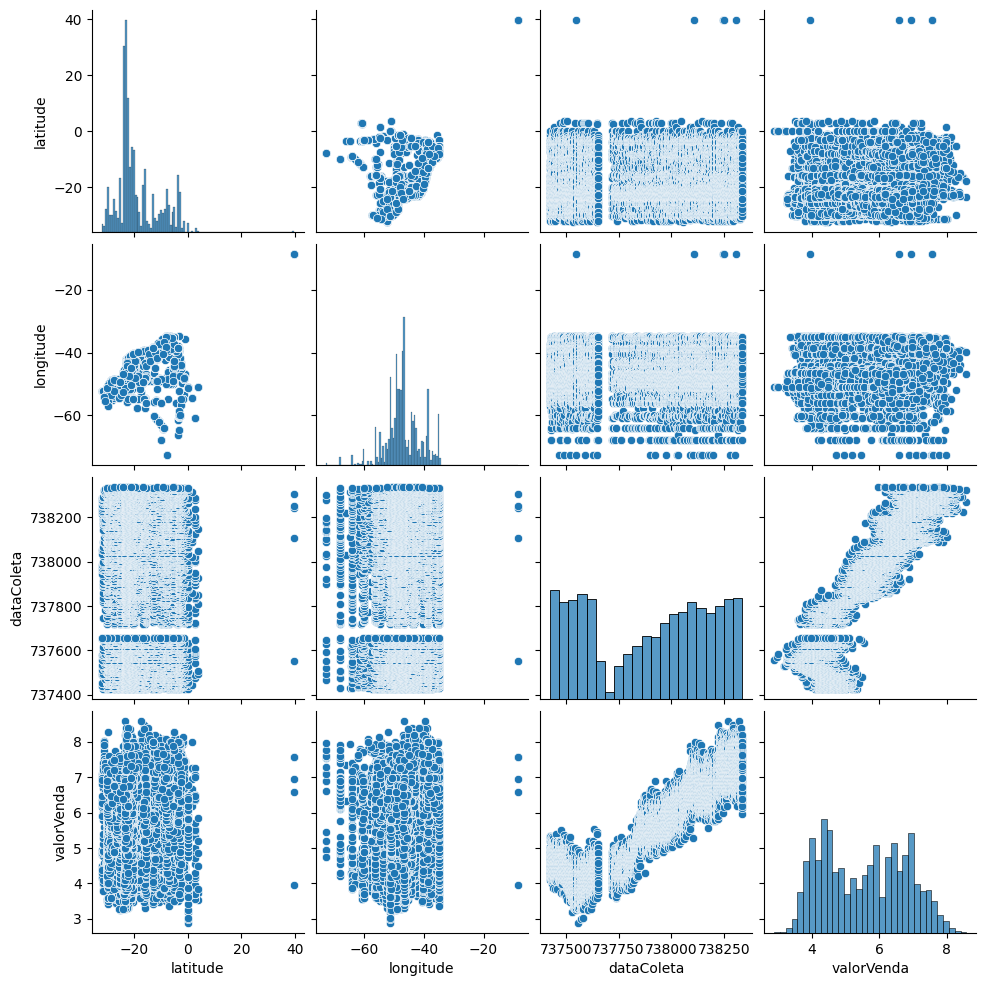

In [163]:
# Relação de todas as colunas do dataframe

sns.pairplot(new_df.iloc[:, :4])

<AxesSubplot: >

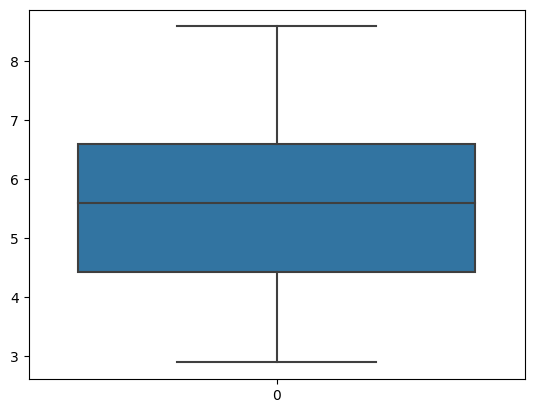

In [191]:
sns.boxplot(new_df['valorVenda'])

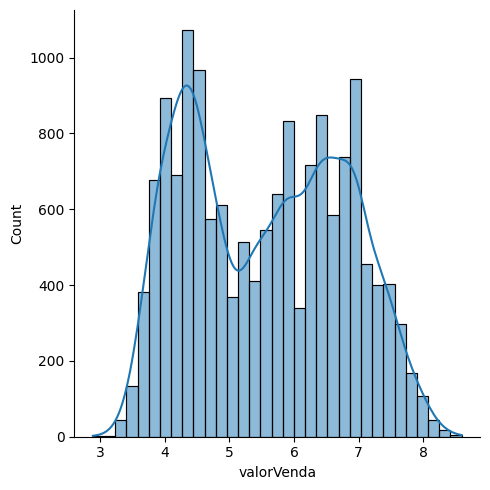

In [242]:
sns.displot(new_df['valorVenda'], kde=True)

# Regressão linear

In [149]:
new_df.columns

Index(['latitude', 'longitude', 'dataColeta', 'valorVenda', 'centroOeste',
       'norte', 'nordeste', 'sul', 'sudeste', 'AC', 'AL', 'AM', 'AP', 'BA',
       'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI',
       'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO'],
      dtype='object')

In [165]:
# Separa as colunas em X (entrada) e Y (saída)

y = new_df['valorVenda']

x = new_df[['latitude', 'longitude', 'dataColeta', 'centroOeste', 'norte', 'nordeste', 'sul', 'sudeste', 'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']]

In [166]:
# Separa o dataframe em 20/80, sendo 20% para teste e o resto para treino

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=721)

In [167]:
model = LinearRegression()

In [168]:
# Treina o modelo

model.fit(X_train, y_train)

LinearRegression()

# Análise do modelo

In [170]:
coeff_df = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])
coeff_df

,Coefficient
latitude,0.004329
longitude,-0.025459
dataColeta,0.003850
centroOeste,-0.044021
norte,-0.283819
nordeste,0.239477
sul,-0.111806
sudeste,0.200169
AC,0.211558
AL,0.098018


In [173]:
print(f'Score da IA: {round(model.score(X_test, y_test) * 100, 2)}%')

Score da IA: 87.86%


In [172]:
predictions = model.predict(X_test)

In [174]:
print('Erro médio absoluto....................: ', round(metrics.mean_absolute_error(y_test, predictions), 3))
print('Erro médio ao quadrado.................: ', round(metrics.mean_squared_error(y_test, predictions), 3))
print('Raiz quadrada do erro médio ao quadrado: ', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 3))

Erro médio absoluto....................:  0.343
Erro médio ao quadrado.................:  0.182
Raiz quadrada do erro médio ao quadrado:  0.427


<AxesSubplot: xlabel='valorVenda'>

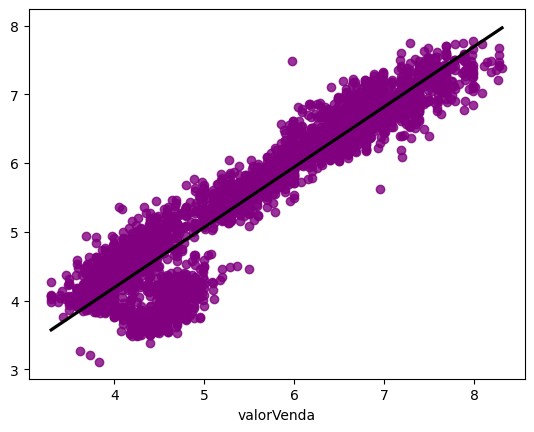

In [231]:
# sns.regplot(x=predictions, y=y_test, scatter_kws={'color':'purple'}, line_kws={'color':'black'})
sns.regplot(x=y_test, y=predictions, scatter_kws={'color':'purple'}, line_kws={'color':'black'})

# Teste de previsão

In [177]:
data = {
    'latitude': [-23.68415086132974],
    'longitude': [-46.50787807009423],
    'dataColeta': [738483],
    'centroOeste':[0],
    'norte':[0],
    'nordeste':[0],
    'sul':[0],
    'sudeste':[1],
    'AC':[0],
    'AL':[0],
    'AM':[0],
    'AP':[0],
    'BA':[0],
    'CE':[0],
    'DF':[0],
    'ES':[0],
    'GO':[0],
    'MA':[0],
    'MG':[0],
    'MS':[0],
    'MT':[0],
    'PA':[0],
    'PB':[0],
    'PE':[0],
    'PI':[0],
    'PR':[0],
    'RJ':[0],
    'RN':[0],
    'RO':[0],
    'RR':[0],
    'RS':[0],
    'SC':[0],
    'SE':[0],
    'SP':[1],
    'TO':[0]
}

try_df = pd.DataFrame(data)
try_df

,latitude,longitude,dataColeta,centroOeste,norte,nordeste,sul,sudeste,AC,AL,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,-23.684151,-46.507878,738483,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [234]:
model.predict(try_df)

array([7.53453403])